In [1]:
from agents import agent_loss, CAPM_Agent, MVP_Agent, Uniform_Agent
from trading_env.environment import TradingEnv

import dill
import random
import matplotlib.pyplot as plt

2021-07-13 00:56:06.090049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-13 00:56:06.090240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
with open('test_data.dill','rb') as dill_file:
    test_data = dill.load(dill_file)
test_dates = test_data['dates']
test_data = test_data['data']

env = TradingEnv(test_data)
n_stocks = env.n_stocks
start = env._start_tick

2021-07-13 00:56:12.646189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-13 00:56:12.646772: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-13 00:56:12.647055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rajinder-Flex-3-1480): /proc/driver/nvidia/version does not exist
2021-07-13 00:56:12.648678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open('dpm_agent.dill','rb') as dill_file:
    dpm_agent = dill.load(dill_file)

capm_agent = CAPM_Agent(n_stocks)
mvp_agent = MVP_Agent(n_stocks)
uniform_agent = Uniform_Agent(n_stocks)

In [4]:
env = TradingEnv(test_data)

dpm_loss = agent_loss(env,dpm_agent,n_stocks)
dpm_val_hist = env.portfolio_value_hist

uniform_loss = agent_loss(env,uniform_agent,n_stocks)
uniform_val_hist = env.portfolio_value_hist

mvp_loss = agent_loss(env,mvp_agent,n_stocks)
mvp_val_hist = env.portfolio_value_hist

capm_loss = agent_loss(env,capm_agent,n_stocks)
capm_val_hist = env.portfolio_value_hist

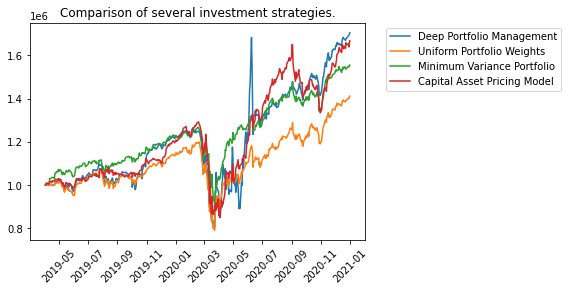

In [5]:
plt.plot(test_dates[start:],dpm_val_hist,label='Deep Portfolio Management')
plt.plot(test_dates[start:],uniform_val_hist,label='Uniform Portfolio Weights')
plt.plot(test_dates[start:],mvp_val_hist,label='Minimum Variance Portfolio')
plt.plot(test_dates[start:],capm_val_hist,label='Capital Asset Pricing Model')
plt.xticks(rotation=45)
plt.legend(loc='upper right',bbox_to_anchor=(1.6, 1) )
plt.title('Comparison of several investment strategies.')
plt.show()

In [8]:
TRIALS = 10
n_trialsize = 5

final_vals = {'DeepPortfolio':[],
              'CAPM':[],
              'MVP':[],
              'Uniform':[]}


capm_agent = CAPM_Agent(n_trialsize)
mvp_agent = MVP_Agent(n_trialsize)
uniform_agent = Uniform_Agent(n_trialsize)

for _ in range(TRIALS):

    sample_idx = random.sample(list(range(n_stocks)),n_trialsize)
    sample = test_data[sample_idx,:,:]

    env = TradingEnv(sample)


    dpm_loss = agent_loss(env,dpm_agent,n_trialsize)
    final_vals['DeepPortfolio'].append(env.portfolio_value_hist[-1])

    capm_loss = agent_loss(env,capm_agent,n_trialsize)
    final_vals['CAPM'].append(env.portfolio_value_hist[-1])

    mvp_loss = agent_loss(env,mvp_agent,n_trialsize)
    final_vals['MVP'].append(env.portfolio_value_hist[-1])

    uniform_loss = agent_loss(env,uniform_agent,n_trialsize)
    final_vals['Uniform'].append(env.portfolio_value_hist[-1])








In [9]:
final_vals

{'DeepPortfolio': [<tf.Tensor: shape=(), dtype=float32, numpy=1769741.1>,
  <tf.Tensor: shape=(), dtype=float32, numpy=956834.25>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1434219.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1581594.2>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1283099.2>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1383596.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1502814.2>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1611766.6>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1257443.1>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1151698.4>],
 'CAPM': [<tf.Tensor: shape=(), dtype=float32, numpy=1245854.4>,
  <tf.Tensor: shape=(), dtype=float32, numpy=792548.1>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1888921.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1545683.8>,
  <tf.Tensor: shape=(), dtype=float32, numpy=791369.94>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1311794.9>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1563008.9>,
  <tf.

In [12]:
import numpy as np

for key,value in final_vals.items():
    print(key)
    print(np.mean(value))


DeepPortfolio
1393280.6
CAPM
1275635.2
MVP
1348363.6
Uniform
1278634.4
